# Sheet 10

## 1 Optimal Transport

In [20]:
import numpy as np

d = 5
num_sources = 10
num_sinks = 20

np.random.seed(42)
mass_sources = np.random.random(num_sources)
mass_sinks = np.random.random(num_sinks)
mass_sources /= np.sum(mass_sources)
mass_sinks /= np.sum(mass_sinks)

coords_sources = np.random.rand(num_sources, d)
coords_sinks = np.random.rand(num_sinks, d)

In [21]:
from scipy.optimize import linprog
import matplotlib.pyplot as plt

In [22]:
# Compute cost matrix
cost = np.linalg.norm(coords_sources[:, None] - coords_sinks, axis=2)
# Flatten cost matrix
c = cost.flatten()

# Construct constraint equations
A_eq = []

# Supply constraints: Each source distributes all its mass
for i in range(num_sources):
    row = np.zeros(num_sources * num_sinks)
    row[i * num_sinks:(i + 1) * num_sinks] = 1
    A_eq.append(row)

# Demand constraints: Each sink receives all its required mass
for j in range(num_sinks):
    row = np.zeros(num_sources * num_sinks)
    row[j::num_sinks] = 1
    A_eq.append(row)

A_eq = np.array(A_eq)
b_eq = np.concatenate([mass_sources, mass_sinks])

# Bounds for each decision variable (non-negative transport plan)
bounds = [(0, None) for _ in range(num_sources * num_sinks)]

# Solve the linear program
result = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

# Extract the optimal transport plan
transport_plan = result.x.reshape(num_sources, num_sinks)
print("Optimal transport plan:")
print(transport_plan)
print("\nTotal transportation cost:", result.fun)


Optimal transport plan:
[[0.         0.         0.0305051  0.         0.02285223 0.
  0.         0.         0.         0.         0.01865067 0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.02796887 0.         0.         0.
  0.         0.06595275 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.03463926
  0.05422072 0.        ]
 [0.         0.12190079 0.01299226 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.00583801]
 [0.         0.         0.00316162 0.         0.         0.01188377
  0.03823796 0.         0.         0.         0.         0.
  0.0367175  0.         0.         0.         0.02509552 0.
  0.         0.        ]
 [0.         0.         0.0299957  0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.     

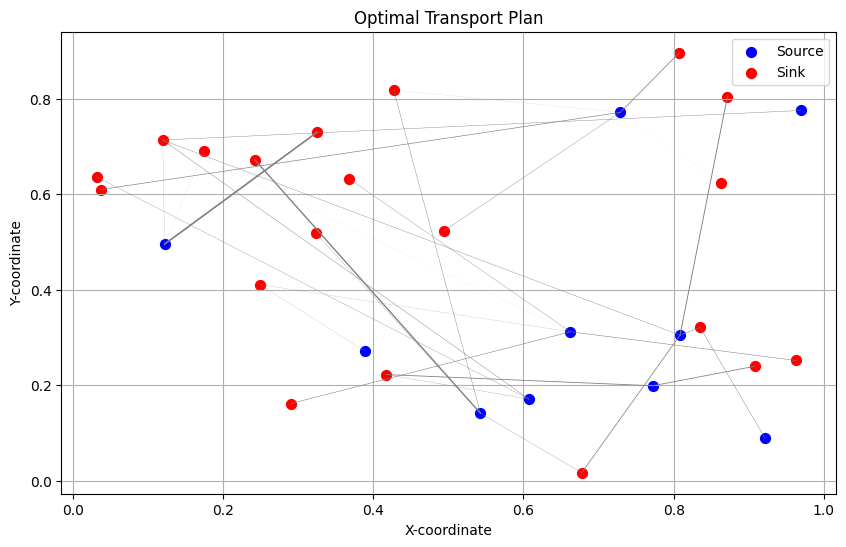

In [23]:
# A 2d representation of the transportation routes
# Note some connections appear to overlap, but this is because the data is really high-dimensional

# Plot sources and sinks with connections
plt.figure(figsize=(10, 6))

# Plot sources
for i, (x, y) in enumerate(coords_sources[:, :2]):
    plt.scatter(x, y, c='blue', label='Source' if i == 0 else "", s=50)
    #plt.text(x, y, f"S{i}", fontsize=8, color='blue')

# Plot sinks
for j, (x, y) in enumerate(coords_sinks[:, :2]):
    plt.scatter(x, y, c='red', label='Sink' if j == 0 else "", s=50)
    #plt.text(x, y, f"T{j}", fontsize=8, color='red')

# Plot connections based on transport plan
for i in range(num_sources):
    for j in range(num_sinks):
        if transport_plan[i, j] > 1e-5:  # Only plot significant connections
            plt.plot(
                [coords_sources[i, 0], coords_sinks[j, 0]],
                [coords_sources[i, 1], coords_sinks[j, 1]],
                'gray', alpha=1.0, lw=10 * transport_plan[i, j]
            )

plt.legend()
plt.title("Optimal Transport Plan")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
plt.grid(True)
plt.show()

## 2 Flow matching for generative modeling

In [ ]:
import torch
import matplotlib.pyplot as plt

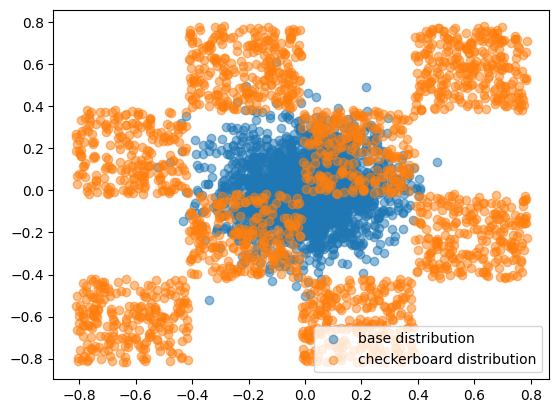

In [28]:
def generate_checkerboard_sample(num_samples=10, field_size=0.4, num_fields=2, center=True):
    x = torch.rand(num_samples, 2) * field_size
    offset = torch.randint(0, num_fields, (num_samples, 2)) * field_size * 2
    diagonal_shift = torch.randint(0, num_fields, (num_samples, 1)) * field_size
    x += offset + diagonal_shift

    if center:
        x -= torch.mean(x, dim=0)

    return x
    
base_distribution_std = 0.15
num_samples = 2000
x = torch.randn(num_samples, 2) * base_distribution_std
y = generate_checkerboard_sample(num_samples=num_samples)

# show points
plt.scatter(x[:, 0], x[:, 1], alpha=0.5, label='base distribution')
plt.scatter(y[:, 0], y[:, 1], alpha=0.5, label='checkerboard distribution')
plt.legend()
plt.show()

In [26]:
from torchvision.ops import MLP
from tqdm import tqdm

c:\Users\samhe\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [33]:
# define a model

device = "cuda" if torch.cuda.is_available() else "cpu"

model = MLP(in_channels=2 + 1, hidden_channels=[512, 512, 512, 512, 2], activation_layer=torch.nn.SiLU)
model.to(device)

# define a loss function
criterion = torch.nn.MSELoss(reduction="none")

# define an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# train the model:
num_epochs = 20000  # use fewer epochs if it takes too long
batch_size = 4096
losses = []
for epoch in tqdm(range(num_epochs)):
    x = torch.randn(batch_size, 2) * base_distribution_std
    y = generate_checkerboard_sample(num_samples=batch_size)
    
    x, y = x.to(device), y.to(device)

    # Time sampling: uniformly in [0, 1]
    t = torch.rand(batch_size, 1).to(device)

    # Interpolated points
    psi_t = (1 - t) * x + t * y

    # Target velocity field
    velocity_field = y - x

    # Predict the velocity field
    input_data = torch.cat([psi_t, t], dim=1)
    predicted_velocity_field = model(input_data)

    # Compute the loss
    loss = criterion(predicted_velocity_field, velocity_field).mean()
    losses.append(loss.item())

    # Optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss every 1000 steps
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, loss: {loss.item()}")


  0%|          | 2/20000 [00:00<2:17:11,  2.43it/s]

Epoch 0, loss: 0.23347346484661102


  5%|▌         | 1001/20000 [02:45<1:04:02,  4.94it/s]

Epoch 1000, loss: 0.10503309220075607


 10%|█         | 2002/20000 [05:34<48:19,  6.21it/s]  

Epoch 2000, loss: 0.10438813269138336


 15%|█▌        | 3002/20000 [08:21<47:29,  5.97it/s]  

Epoch 3000, loss: 0.10168859362602234


 20%|██        | 4001/20000 [11:53<1:17:12,  3.45it/s]

Epoch 4000, loss: 0.10369347780942917


 25%|██▌       | 5001/20000 [16:01<58:13,  4.29it/s]  

Epoch 5000, loss: 0.10190066695213318


 30%|███       | 6001/20000 [20:04<55:03,  4.24it/s]  

Epoch 6000, loss: 0.1026170551776886


 35%|███▌      | 7001/20000 [24:12<54:40,  3.96it/s]  

Epoch 7000, loss: 0.10358843207359314


 40%|████      | 8001/20000 [28:15<46:26,  4.31it/s]  

Epoch 8000, loss: 0.09900793433189392


 45%|████▌     | 9001/20000 [32:19<43:19,  4.23it/s]  

Epoch 9000, loss: 0.1022731214761734


 50%|█████     | 10001/20000 [36:24<40:09,  4.15it/s]

Epoch 10000, loss: 0.10242508351802826


 55%|█████▌    | 11001/20000 [40:27<35:43,  4.20it/s]

Epoch 11000, loss: 0.10519292205572128


 60%|██████    | 12001/20000 [44:29<30:33,  4.36it/s]

Epoch 12000, loss: 0.09910440444946289


 65%|██████▌   | 13001/20000 [48:33<27:09,  4.29it/s]

Epoch 13000, loss: 0.10274646431207657


 70%|███████   | 14001/20000 [52:35<23:12,  4.31it/s]

Epoch 14000, loss: 0.10280335694551468


 75%|███████▌  | 15001/20000 [56:40<20:35,  4.05it/s]

Epoch 15000, loss: 0.1053009033203125


 80%|████████  | 16001/20000 [1:00:46<16:21,  4.08it/s]

Epoch 16000, loss: 0.10330592840909958


 85%|████████▌ | 17001/20000 [1:04:50<11:47,  4.24it/s]

Epoch 17000, loss: 0.0992320328950882


 90%|█████████ | 18001/20000 [1:08:53<08:26,  3.95it/s]

Epoch 18000, loss: 0.10263832658529282


 95%|█████████▌| 19001/20000 [3:04:12<03:57,  4.20it/s]      

Epoch 19000, loss: 0.1026948019862175


100%|██████████| 20000/20000 [3:07:06<00:00,  1.78it/s]


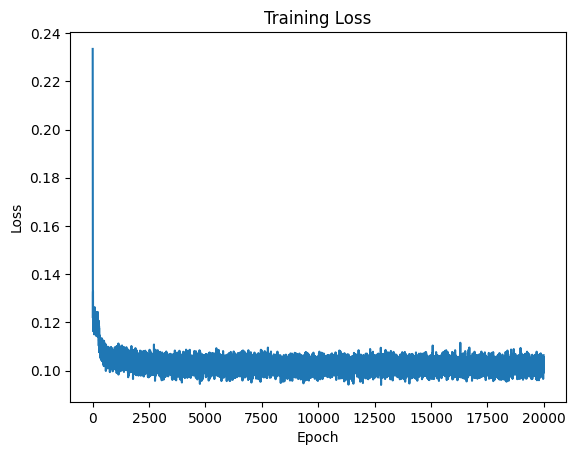

In [34]:
# Visualise losses

plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [35]:
# TODO: run inference with the trained model. 
# Visualize the trajectory of the samples and the final samples at t=1.
# Hint: Use a simple Euler integration scheme to integrate the velocity field with 100 steps.

# Visualization function
def plot_samples(base_samples, target_samples, title="Samples"):
    plt.figure(figsize=(8, 6))
    plt.scatter(base_samples[:, 0], base_samples[:, 1], alpha=0.5, label='Base Distribution')
    plt.scatter(target_samples[:, 0], target_samples[:, 1], alpha=0.5, label='Target Distribution')
    plt.title(title)
    plt.legend()
    plt.show()

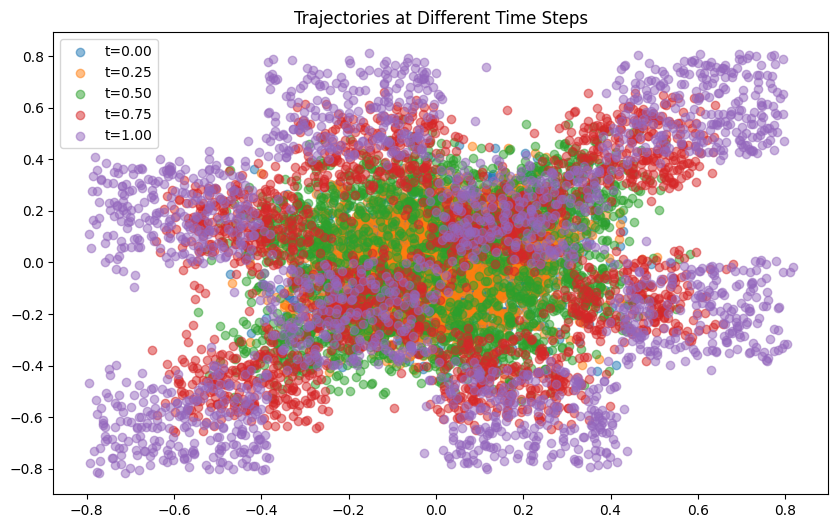

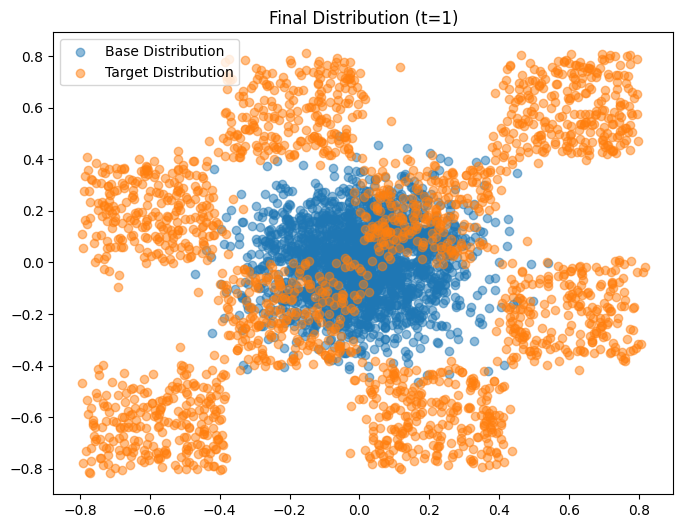

In [36]:
# Inference: Euler integration
def euler_integration(model, x0, steps=100, t0=0.0, t1=1.0):
    dt = (t1 - t0) / steps
    t = torch.linspace(t0, t1, steps + 1).to(device)
    trajectory = [x0]
    current_x = x0.clone().to(device)

    for step in range(steps):
        current_t = t[step].repeat(current_x.size(0), 1)
        input_data = torch.cat([current_x, current_t], dim=1)
        v_t = model(input_data)  # Predict velocity
        current_x = current_x + v_t * dt  # Update position
        trajectory.append(current_x.detach().cpu())

    return torch.stack(trajectory, dim=0)

# Run inference and visualize trajectories
x0 = torch.randn(num_samples, 2) * base_distribution_std  # Initial samples
x0 = x0.to(device)
trajectories = euler_integration(model, x0, steps=100)

# Visualize initial, intermediate, and final samples
plt.figure(figsize=(10, 6))
for t_step in [0, 25, 50, 75, 100]:
    samples = trajectories[t_step]
    plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5, label=f"t={t_step / 100:.2f}")
plt.title("Trajectories at Different Time Steps")
plt.legend()
plt.show()

# Visualize final distribution
final_samples = trajectories[-1]
plot_samples(x0.cpu(), final_samples.cpu(), title="Final Distribution (t=1)")


In [42]:
time_steps = np.linspace(0, 100, 11)
time_steps.astype(int)

array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100])

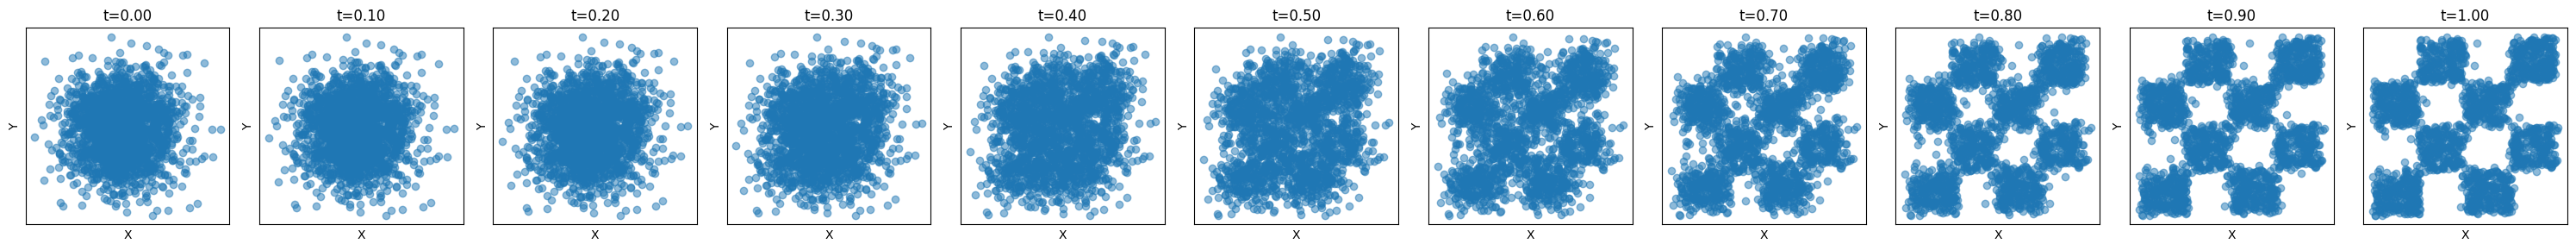

In [46]:
# Plot trajectories at different time steps in subplots
time_steps = np.linspace(0, 100, 11).astype(int)  # Time steps to visualize
num_steps = len(time_steps)

plt.figure(figsize=(30, 3))  # Set the figure size to accommodate subplots

for i, t_step in enumerate(time_steps):
    plt.subplot(1, num_steps, i + 1)  # Create a subplot for each time step
    samples = trajectories[t_step]
    plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
    plt.title(f"t={t_step / 100:.2f}")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()


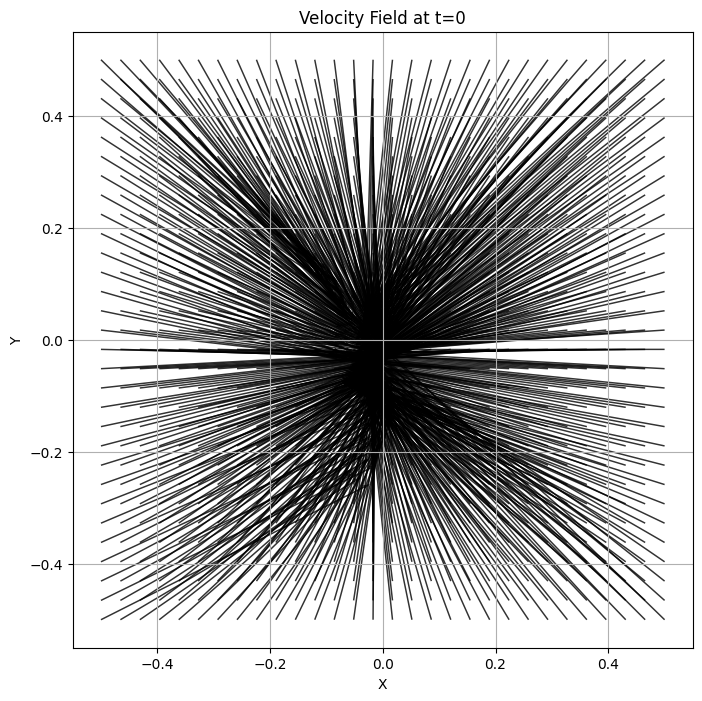

In [48]:
# Generate a grid in [-0.5, 0.5]^2
grid_x, grid_y = torch.meshgrid(torch.linspace(-0.5, 0.5, 30), torch.linspace(-0.5, 0.5, 30))
grid_points = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=-1).to(device)

# Evaluate the model's velocity field at t=0
t_zero = torch.zeros(grid_points.size(0), 1).to(device)  # t=0 for all points
input_data = torch.cat([grid_points, t_zero], dim=1)
velocity_field = model(input_data).detach().cpu()

# Reshape for plotting
velocity_field_x = velocity_field[:, 0].reshape(grid_x.shape)
velocity_field_y = velocity_field[:, 1].reshape(grid_y.shape)

# Convert tensors to numpy arrays for plotting
grid_x_np = grid_x.cpu().numpy()
grid_y_np = grid_y.cpu().numpy()
velocity_field_x_np = velocity_field_x.cpu().numpy()
velocity_field_y_np = velocity_field_y.cpu().numpy()

# Plot the velocity field
plt.figure(figsize=(8, 8))
plt.quiver(
    grid_x_np, grid_y_np, velocity_field_x_np, velocity_field_y_np,
    angles="xy", scale_units="xy", scale=1, alpha=0.8
)
plt.title("Velocity Field at t=0")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()


## 3 Adversarial attacks and AI safety

In [49]:
'''
Logistric regression in pytorch (needed for backpropagation)
taken from https://github.com/saprmarks/geometry-of-truth/blob/main/probes.py
'''

class LRProbe(torch.nn.Module):
    def __init__(self, d_in):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(d_in, 1, bias=False),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)

    def pred(self, x):
        return self(x).round()
    
    def from_data(acts, labels, lr=0.001, weight_decay=0.1, epochs=1000, device='cpu'):
        acts, labels = acts.to(device), labels.to(device)
        probe = LRProbe(acts.shape[-1]).to(device)
        
        opt = torch.optim.AdamW(probe.parameters(), lr=lr, weight_decay=weight_decay)
        for _ in range(epochs):
            opt.zero_grad()
            loss = torch.nn.BCELoss()(probe(acts), labels)
            loss.backward()
            opt.step()
        
        return probe

    def __str__():
        return "LRProbe"

    @property
    def direction(self):
        return self.net[0].weight.data[0]

In [52]:
# We import the DataManager class as a helper function to load the activation vectors for us.
from data.lie_detection.utils import DataManager
from sklearn.metrics import accuracy_score

path_to_datasets = "data/lie_detection/datasets"
path_to_acts = "data/lie_detection/acts"

In [54]:
# train a model on the cities dataset
dataset_name = "cities"

dm = DataManager()
#dm.add_dataset(dataset_name, "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
#                device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
dm.add_dataset(dataset_name, "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
               device='cpu')
train_acts, train_labels = dm.get('train')
test_acts, test_labels = dm.get('val')

print("train_acts.shape", train_acts.shape)
print("test_acts.shape", test_acts.shape)

# Train a logistic regression probe on the train_acts and train_labels

# Train the logistic regression probe
probe = LRProbe.from_data(train_acts, train_labels, lr=0.001, weight_decay=0.1, epochs=1000, device='cpu')

# Evaluate on the test set
preds = probe.pred(test_acts)
accuracy = accuracy_score(test_labels, preds)
print(f"Accuracy of the trained probe: {accuracy:.2f}")


RuntimeError: torch.cat(): expected a non-empty list of Tensors

In [ ]:
# TODO: optimize a perturbation on a single sample which is a lie

In [ ]:
# TODO: check whether this perturbation works on other samples too

In [33]:
# TODO: add the constraint that the perturbation should be small